In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytesseract

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-m9p6r59r
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-m9p6r59r
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6733342 sha256=2fd58a6a96c0f3f7bc74e89a1d0614e2c909deef794afcdd22a6ce273dac36d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-930qtyvd/wheels/d3/6e/bd/1969578f1456a6be

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import os

class ImageDataset(Dataset):
    def __init__(self,txt_path,img_path,box_path,processor,label2id,img_dir):
        self.words,self.labels,self.bboxes,self.images = self._load_data(txt_path,img_path,box_path,img_dir)
        self.processor = processor
        self.label2id = label2id

    def _load_data(self,txt_path,img_path,box_path,img_dir):
        words_per_doc,labels_per_doc,bboxes_per_doc,images = [],[],[],[]
        with open(txt_path,'r',encoding='utf-8') as f_text,\
             open(img_path,'r',encoding='utf-8') as f_img,\
             open(box_path,'r',encoding='utf-8') as f_box:

            words,labels,boxes = [],[],[]
            curr_file_name = None
            img = None

            for (line_text,line_img,line_box) in zip(f_text,f_img,f_box):
                if line_text.strip() == "":
                    if words:
                        words_per_doc.append(words)
                        labels_per_doc.append(labels)
                        bboxes_per_doc.append(boxes)
                        images.append(img)
                        words,labels,boxes = [],[],[]
                    continue

                word,label = line_text.strip().split("\t")
                word_box = list(map(int, line_box.strip().split("\t")[1].split()))
                img_info = line_img.strip().split("\t")
                filename = img_info[-1]

                if curr_file_name != filename:
                    curr_file_name = filename
                    img = Image.open(os.path.join(img_dir,filename)).convert("RGB")

                words.append(word)
                labels.append(label)
                boxes.append(word_box)

        return words_per_doc,labels_per_doc,bboxes_per_doc,images

    def __len__(self):
        return len(self.words)

    def __getitem__(self,idx):
        encoding = self.processor(
            self.images[idx],
            self.words[idx],
            boxes=self.bboxes[idx],
            word_labels=[self.label2id[label] for label in self.labels[idx]],
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors="pt"
        )
        return {k:v.squeeze(0) for k,v in encoding.items()}

In [ ]:
label2id = {
    "O": 0,
    "S-COMPANY": 1,
    "S-DATE": 2,
    "S-ADDRESS": 3,
    "S-TOTAL": 4,
}

id2label = {v:k for k,v in label2id.items()}

In [ ]:
from transformers import LayoutLMv2ForTokenClassification,LayoutLMv2Processor, Trainer, TrainingArguments

processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased",apply_ocr = False)
model = LayoutLMv2ForTokenClassification.from_pretrained("microsoft/layoutlmv2-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [ ]:
train_dataset = ImageDataset(
    txt_path="/content/drive/MyDrive/UnikrewTest/processed_data/train/train.txt",
    img_path="/content/drive/MyDrive/UnikrewTest/processed_data/train/train_img.txt",
    box_path="/content/drive/MyDrive/UnikrewTest/processed_data/train/train_box.txt",
    processor=processor,
    label2id=label2id,
    img_dir="/content/drive/MyDrive/UnikrewTest/dataset/train/img"
)
# print(len(train_dataset))
test_dataset = ImageDataset(
    txt_path="/content/drive/MyDrive/UnikrewTest/processed_data/test/test.txt",
    img_path="/content/drive/MyDrive/UnikrewTest/processed_data/test/test_img.txt",
    box_path="/content/drive/MyDrive/UnikrewTest/processed_data/test/test_box.txt",
    processor=processor,
    label2id=label2id,
    img_dir="/content/drive/MyDrive/UnikrewTest/dataset/test/img"
)

187


In [ ]:
import torch
from collections import Counter

# Label counts from earlier
label_counts = {
    "O": 20300,
    "S-ADDRESS": 73,
    "S-TOTAL": 188,
    "S-DATE": 97,
    "S-COMPANY": 24,
}

# Convert to tensor of weights in same order as label2id
total = sum(label_counts.values())
weights = torch.tensor([
    total / label_counts[label] for label in label2id.keys()
], dtype=torch.float)

weights = weights / weights.sum() * len(weights)  # normalize
# print(weights)

tensor([0.0035, 2.9325, 0.7256, 0.9641, 0.3744])


In [ ]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=weights.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/UnikrewTest/modules/output",
    num_train_epochs=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    learning_rate=3e-5,
    warmup_ratio = 0.1,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/UnikrewTest/modules/logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=200,
    # save_steps=100,
    save_total_limit=1,
    fp16=True,
    report_to= "none",
    load_best_model_at_end=True,
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # processing_class=processor,
)

In [ ]:

trainer.train()

trainer.save_model("/content/drive/MyDrive/UnikrewTest/modules/model")

Epoch,Training Loss,Validation Loss
1,No log,0.955037
2,No log,0.819371
3,0.955200,0.795834
4,0.955200,0.907768
5,0.572500,0.862195
6,0.572500,0.802466
7,0.364500,0.948796
8,0.364500,0.904624
9,0.233600,0.910038
10,0.233600,0.970621


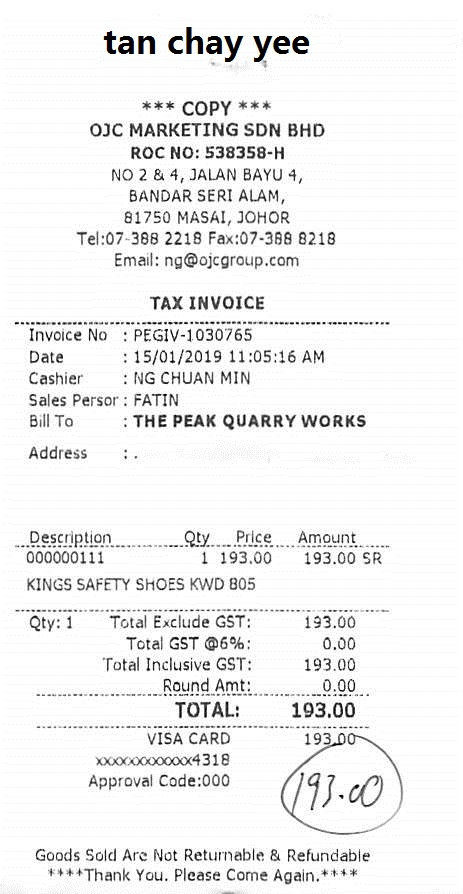

In [ ]:
img = test_dataset.images[0]
display(img)   # or display(img) in Colab